## Тема лекции: 
## Подход Хьюбера к определению оптимальной функции потерь при $ \alpha $ -загрязненных помехах

## 1. Выбросы и их причины

* Ошибки измерений и регистрации данных: ошибки точности измерений, некорректно проведенные наблюдения, некорректная регистрация данных или ошибки при вводе данных в БД(опечатки, не там стоит запятая).

<img src="i_dpz_crop.jpg" />

* Загрязнение данных: данные принадлежат двум и более распределениям, т.е. имеется одно основное распределение и одно или несколько дополнительных распределений (примесей), загрязняющий данные. Экстремальные наблюдения, принадлежащие распределениям-примесям, могут появиться как выбросы основного распределения.



* Ошибочное предположение о распределении данных. Например, истинное распределение может быть сильно ассиметричным или симметричным, но иметь тяжелые хвосты.


* Редкие наблюдения. В выборках, отобранных(как предполагается) из заданных распределений маловероятные наблюдения могут появиться в очень редких случаях. Экстремальные наблюдения в этом случае обычно принимаются за выбросы, но они ими не являются. 

## 2. $ \alpha$-загрязненная помеха

In [2]:
import numpy as np
from scipy.stats import rv_continuous
import matplotlib.pyplot as plt
%matplotlib inline

class gaussian_gen(rv_continuous):
    
    def _pdf(self, x, alpha, sigma_1, sigma_2):
        "Gaussian distribution"
        def gaussian(self, x, sigma):
            return np.exp(-x**2 / 2. / sigma**2) / (np.sqrt(2.0 * np.pi)*sigma)
        
        return (1-alpha)*gaussian(self, x, sigma_1)+alpha*gaussian(self, x, sigma_2)

gaussian = gaussian_gen(name='dirty_distrib')

### Приближенно нормальное распределение

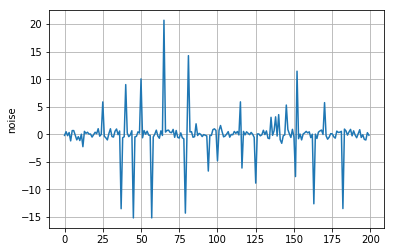

In [5]:
alpha = 0.1 # вероятность появления наблюдения из примеси 
sigma_1 = 0.5 # разброс основного распределения
sigma_2 = 10 # разброс распределения-примеси
N=200 # размер выборки
noise = gaussian.rvs(alpha, sigma_1, sigma_2, size=N)

plt.plot(noise)
plt.ylabel('noise')
plt.grid()

## 3. Чувствительность МНК к выбросам. Пример МНК и HuberRegressor

$ MSE : \sum (y_i - \hat{y}_i)^2 - квадратичная\_\_функция\_\_потерь$
<br>$ MAE : \sum |y_i - \hat{y}_i| - модульная\_\_функция\_\_потерь$ 
<br> $ Huber: \begin{equation} L_\delta(y_i, \hat{y}_i))= \left\{
    \begin{array}\\
        \frac{1}{2}(y_i - \hat{y}_i)^2, & |y_i - \hat{y}_i| < \delta \\
        \delta|y_i - \hat{y}_i| - \frac{1}{2}\delta^2, & иначе\\
    \end{array}  
\right.\end{equation}- функция\_\_потерь\_\_Хьюбера$

<img src="losses.png" />

In [16]:
from sklearn.linear_model import LinearRegression, HuberRegressor
import random

In [17]:
n = 50
x = np.linspace(0, 10, n)

In [18]:
y = 4 + 0.5*x

In [19]:
noise = np.random.normal(0, 0.5, n)
y_new = y + noise

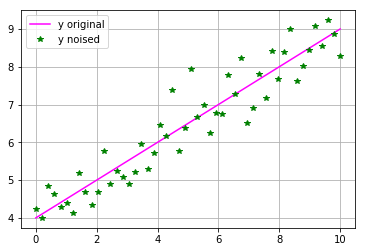

In [20]:
plt.plot(x, y, 'magenta', label='y original')
plt.plot(x, y_new, 'g*', label='y noised')
plt.grid()
plt.legend()

Добавим выбросов в данные

In [21]:
outliers = [25.6, 34.2, 44, 29, 50, 100, 90]
outliers_ind = random.sample(range(len(x)), len(outliers))

for i in range(len(outliers)): 
    y_new[outliers_ind[i]] = outliers[i]

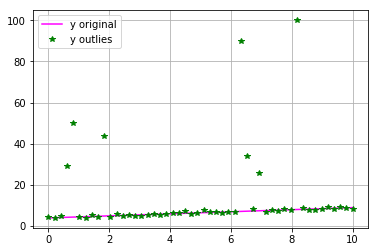

In [23]:
plt.plot(x, y, 'magenta', label='y original')
plt.plot(x, y_new, 'g*', label='y outlies')
plt.grid()
plt.legend()

Определим параметры $ y=kx+b $ с помощью МНК

In [27]:
reg_mse = LinearRegression()
reg_mse.fit(x[:, np.newaxis], y_new)
print('k=', round(reg_mse.coef_[0], 3), 'b=', round(reg_mse.intercept_, 3))

k= 0.619 b= 9.981


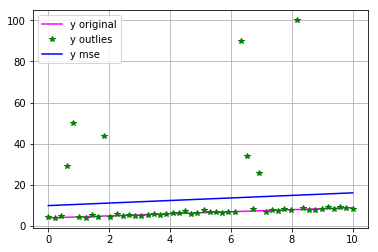

In [28]:
plt.plot(x, y, 'magenta', label='y original')
plt.plot(x, y_new, 'g*', label='y outlies')
plt.plot(x, reg_mse.coef_[0]*x + reg_mse.intercept_, 'b', label='y mse')
plt.grid()
plt.legend()

Попробуем определить параметры $ y = kx+b $ с помощью функции потерь Хьюбера

In [34]:
reg_huber = HuberRegressor()
reg_huber.fit(x[:, np.newaxis], y_new)
print('Huber: ', 'k=', round(reg_huber.coef_[0], 3), 'b=', round(reg_huber.intercept_, 3))
print('MSE:   ', 'k=', round(reg_mse.coef_[0], 3), 'b=', round(reg_mse.intercept_, 3))
print('Original:', 'k=', round(0.5, 3), 'b=', round(4, 3))

Huber:  k= 0.485 b= 4.149
MSE:    k= 0.619 b= 9.981
Original: k= 0.5 b= 4


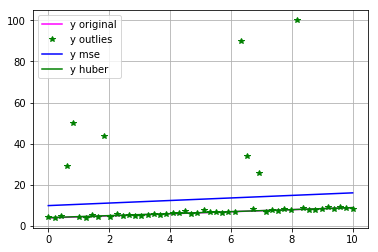

In [35]:
plt.plot(x, y, 'magenta', label='y original')
plt.plot(x, y_new, 'g*', label='y outlies')
plt.plot(x, reg_mse.coef_[0]*x + reg_mse.intercept_, 'b', label='y mse')
plt.plot(x, reg_huber.coef_[0]*x + reg_huber.intercept_, 'g', label='y huber')
plt.grid()
plt.legend()

### Реализация HuberRegressor в scikit-learn

https://github.com/scikit-learn/scikit-learn/blob/95d4f0841d57e8b5f6b2a570312e9d832e69debc/sklearn/linear_model/_huber.py#L17